# For things to work smoothly, we need to import kmedians from the local version of vq, or replace your scipy vq.py file with the one in this folder

In [14]:
from numpy import array
import inspect
import subprocess
import shlex
import numpy as np
import scipy
import scipy.cluster.vq as vq1
from scipy.cluster.vq import vq, kmeans, whiten, kmedians
#from vq import vq, kmeans, whiten, kmedians  ## issues with this
import matplotlib.pyplot as plt
import os
import time
print(os.path.abspath(scipy.cluster.vq.__file__))
colors = ["#2078B5", "#FF7F0F", "#2CA12C", "#D72827", "#9467BE", "#8C574B",
            "#E478C2", "#808080", "#BCBE20", "#17BED0", "#AEC8E9", "#FFBC79", 
            "#98E08B", "#FF9896", "#C6B1D6", "#C59D94", "#F8B7D3", "#C8C8C8", 
           "#DCDC8E", "#9EDAE6"]

/Users/Winston/anaconda3/lib/python3.6/site-packages/scipy/cluster/vq.py


# Create Data

In [15]:
PATH = 'cart-1.2.2/'
N = 50000           #default number of points to draw from distribution
dist_type = "exp"

dimx = 512
dimy = 512
pixel_gap = 150
plot = "'True'"


# MAKE SHELL SCRIPT 
file = open("dist_gen.sh","w") 
file.write("#!/bin/sh\n") 
file.write("python new_dist_gen.py -N "+str(N) +" -d "+str(dist_type)+" -x "+str(dimx)+ \
    " -y "+str(dimy)+" -p "+str(pixel_gap) + " -P "+str(plot)+"\n")
# for different sizes and distributions, check help doc on new_dist_gen.py
# file.write("python new_dist_gen.py\n")

file.close() 

# MAKE EXECUTABLE
p=subprocess.call(['chmod','a+x',"dist_gen.sh"])


p = subprocess.Popen(['./'+"dist_gen.sh"], stdout=subprocess.PIPE, stderr=subprocess.PIPE) 
p.wait()

0

# Show Distribution

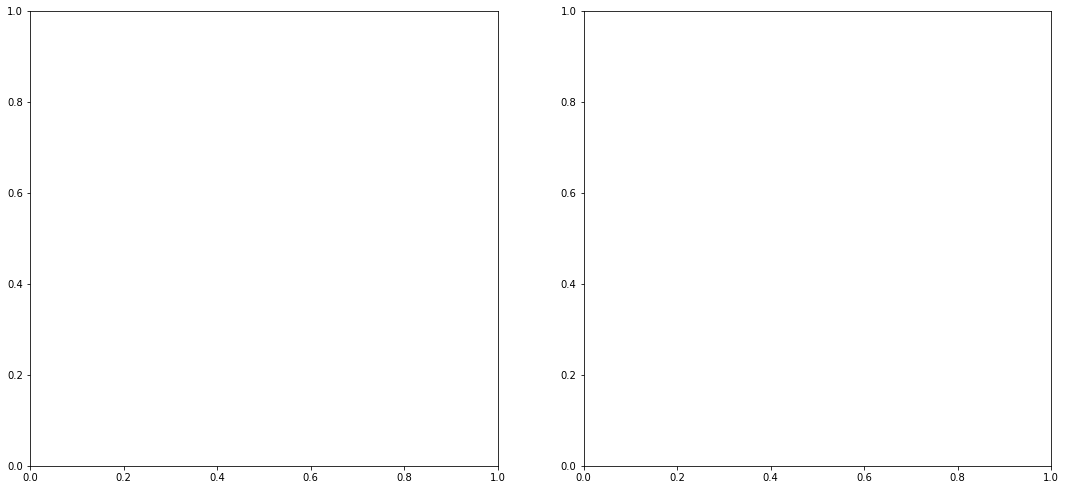

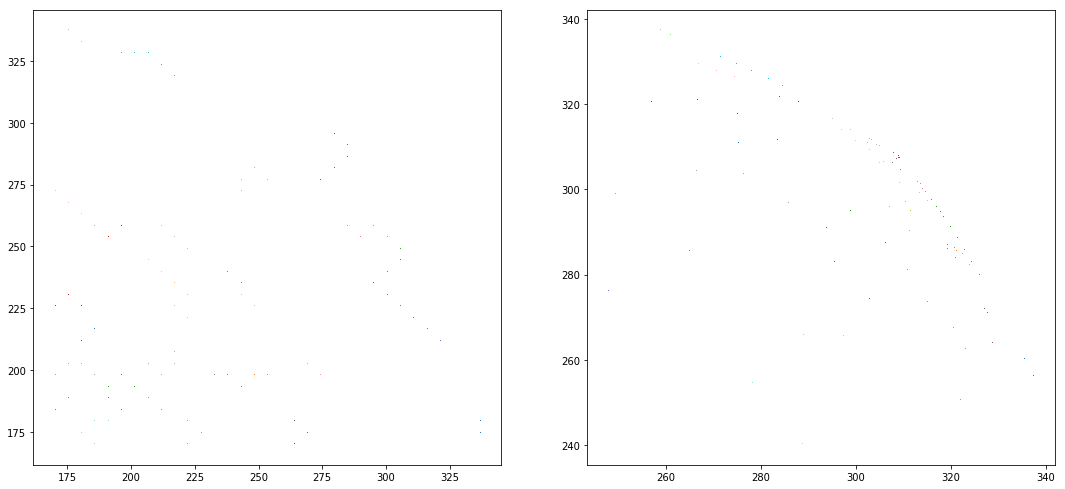

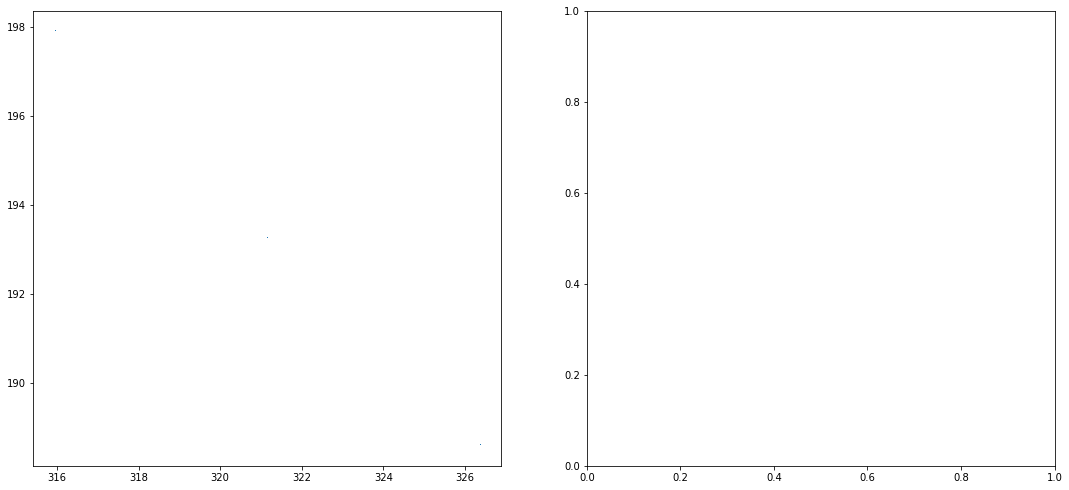

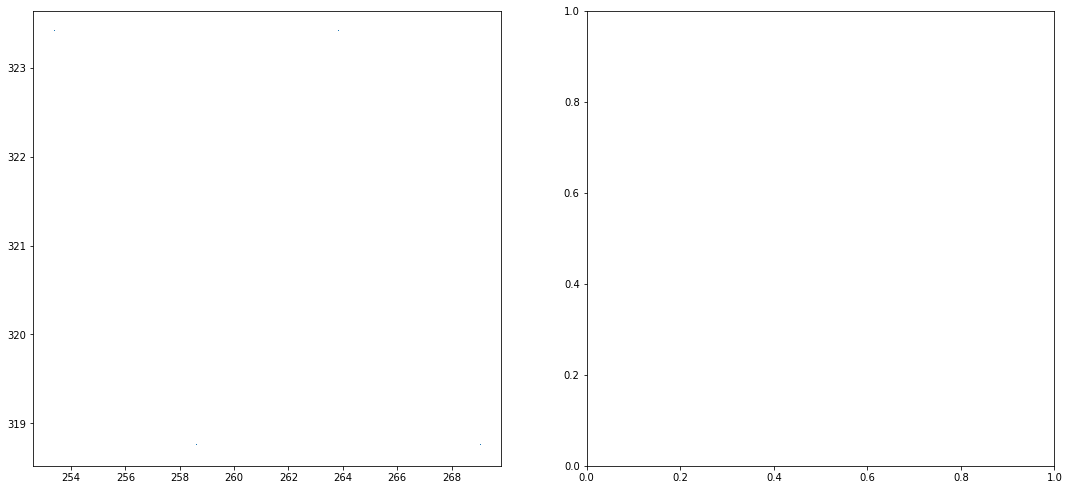

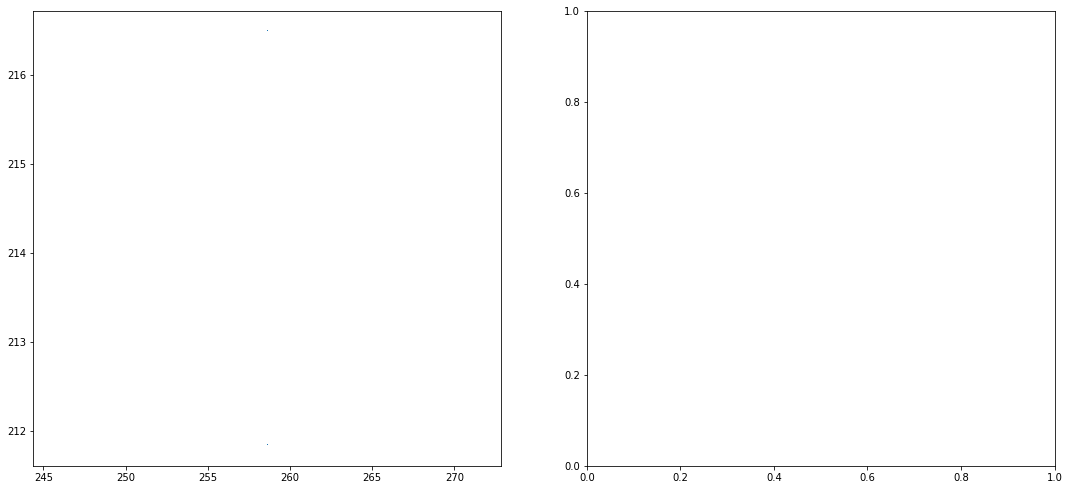

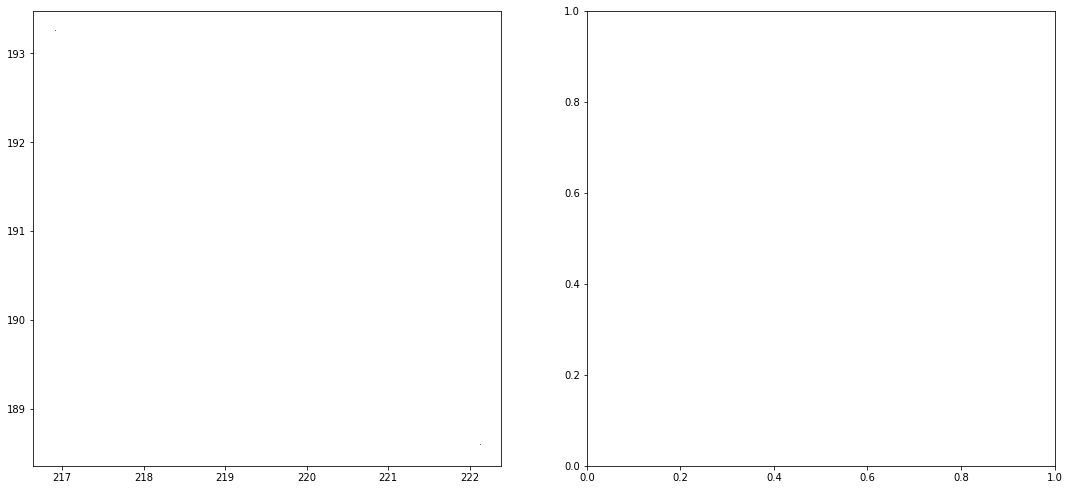

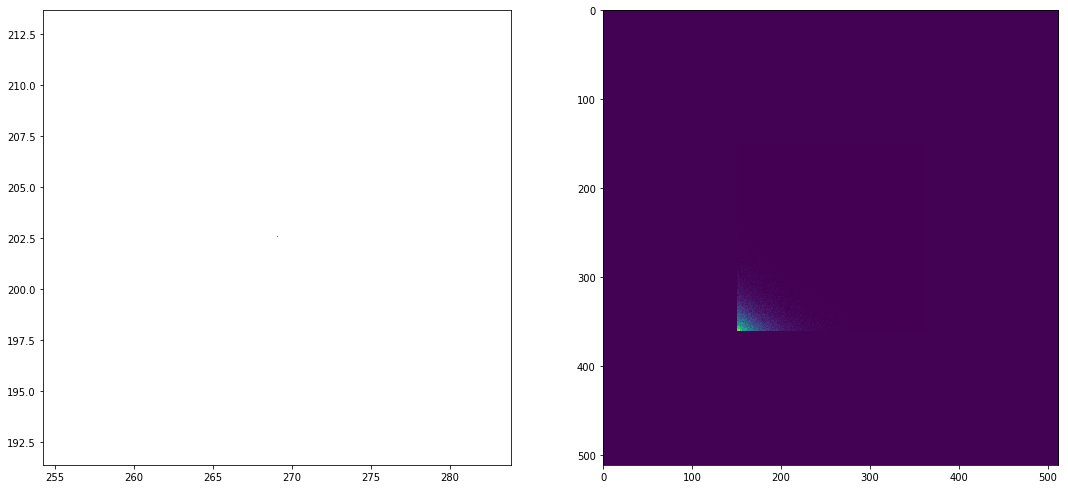

In [16]:
newdist = np.loadtxt('cart-1.2.2/'+str(dimx)+str(dimy)+str(dist_type)+'.dat')
plt.imshow(np.rot90(newdist))
plt.show()

In [17]:
dat2 = np.loadtxt('cart-1.2.2/xy'+str(dimx)+str(dimy)+str(dist_type)+'.dat')

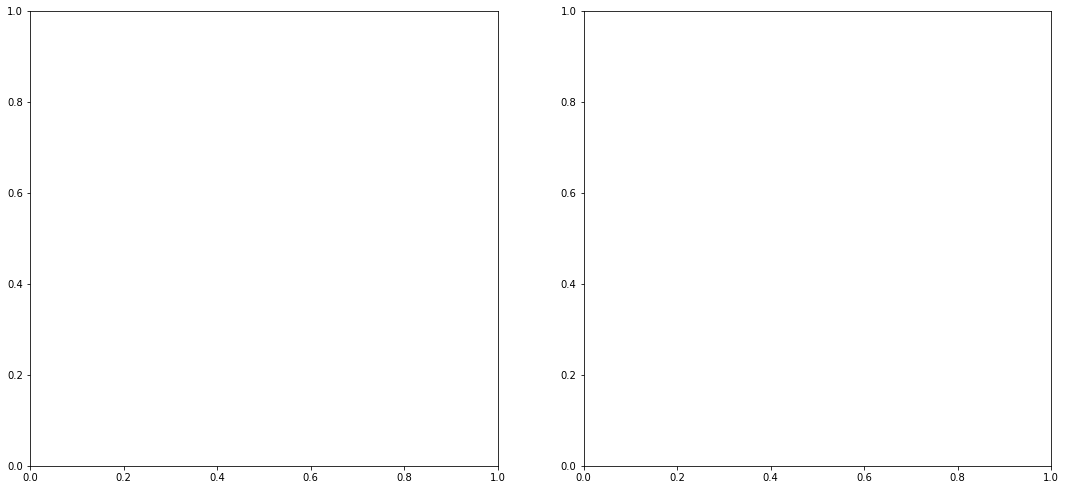

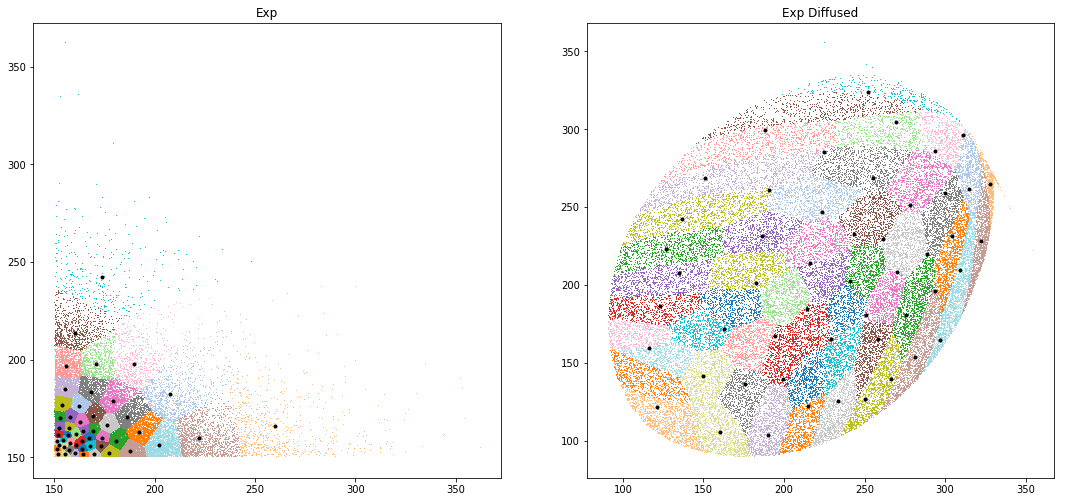

In [20]:

file = open(PATH+"exp_cart.sh","w") 
file.write("#!/bin/sh\n") 
file.write("./cart "+str(dimx) +" "+str(dimy)+" "+str(dimx)+str(dimy)+str(dist_type)+'.dat '+str(dist_type)+"out.dat"+"\n")
file.close() 

# MAKE EXECUTABLE
p=subprocess.call(['chmod','a+x',PATH+"exp_cart.sh"])


p=subprocess.Popen(['./exp_cart.sh'], cwd =PATH) # makes expout.dat
p.wait()
#p=subprocess.Popen(['./gauss_cart.sh'], cwd =PATH)
#p.wait()

N=50                                       # number of clusters
f, axs = plt.subplots(1, 2,figsize=(15,7))

plt.tight_layout(pad=1.4, w_pad=5.5, h_pad=13.0)
axs = axs.ravel()
data_list = [dat2]
titles = ["Exp","Exp Diffused"]
types = ['exp']

dat = np.zeros([1,2])
dat4 = np.zeros([1,2])

for k,j in enumerate([0]):
    
    features = data_list[k]
    codebook, distortion = kmedians(features,N)
    code, dist= vq(features,codebook)
    
    for i in range(N):
        
        # MAKE SHELL SCRIPT 
        file = open(PATH+"interp"+types[k]+str(i)+".sh","w") 
        file.write("#!/bin/sh\n") 
        file.write("cat "+types[k]+str(i)+".dat | ./interp "+str(dimx)+" "+str(dimy)+" "\
                   +types[k]+"out.dat > "+types[k]+"out"+str(i)+".dat\n")
        file.write("cat "+"dif"+types[k]+str(i)+".dat | ./interp "+str(dimx)+" "+str(dimy)+" "\
                   +types[k]+"out.dat > "+"dif"+types[k]+"out"+str(i)+".dat\n")
        file.close()  
                    
        # MAKE EXECUTABLE
        p=subprocess.call(['chmod','a+x',PATH+"interp"+types[k]+str(i)+".sh"])
        # save data to go to interp
        x = features[code==i,0]
        y = features[code==i,1]
        
        
        np.savetxt(PATH+types[k]+str(i)+'.dat',np.column_stack([x,y]),fmt ='%.18f',delimiter=' ')
        #np.savetxt(PATH+"dif"+types[k]+str(i)+'.dat',np.column_stack([codebook[:,0],codebook[:,1]]),fmt ='%.18f',delimiter=' ')
        
        # plot
        axs[j].plot(x,y,',', c=colors[i%len(colors)])
        
        # call interp
        p = subprocess.Popen(['./'+"interp"+types[k]+str(i)+".sh"], cwd =PATH) # makes expout.dat
        p.wait()        
        
        # loads data to run through interp shell script
        data=np.loadtxt(PATH+types[k]+'out'+str(i)+'.dat') #Gaussout0.dat
        
        

        axs[j+1].plot(data[:,0],data[:,1],',', c=colors[i%len(colors)])
        if types[k]=="exp":
            dat = np.append(dat,data,axis=0)
        elif types[k]=="gauss":
            dat4 = np.append(dat4,data,axis=0)
        
        # delete used shell script
        p = subprocess.call(['rm',PATH+"interp"+types[k]+str(i)+".sh"])
        
        p = subprocess.call(['rm',PATH+types[k]+"out"+str(i)+".dat"])
        p = subprocess.call(['rm',PATH+types[k]+str(i)+".dat"])
        
        
                             
    axs[j].plot(codebook[:,0],codebook[:,1],'ko',ms=3)
    
    dif_medians = np.loadtxt(PATH+'dif'+types[k]+'out'+str(i)+'.dat')
    axs[j+1].plot(dif_medians[:,0],dif_medians[:,1],'ko',ms=3)
        
for j in range(2):    
    axs[j].set_title(titles[j])

plt.show()

In [12]:
bin_min = 190
bin_max = 265

#axs[1].plot([bin_min, bin_min,bin_max,bin_max,bin_min], [bin_min,bin_max,bin_max,bin_min,bin_min], 'k-',lw=.5) 
#axs[3].plot([bin_min, bin_min,bin_max,bin_max,bin_min], [bin_min,bin_max,bin_max,bin_min,bin_min], 'k-',lw=.5) 
    
    
## Histograms
binsize = 30
bigbin = 20

## exp raw
Hexdat,xedge,yedge=np.histogram2d(dat2[:,0],dat2[:,1],bins=[binsize,binsize],range=[[200, 270], [200, 270]]) 

H,xedge,yedge=np.histogram2d(dat[:,0],dat[:,1],bins=[binsize,binsize],range=[[bin_min, bin_max], [bin_min, bin_max]]) #BINS = SIZE/2*PIXELGAP

## Gauss Raw
H2,xedge,yedge=np.histogram2d(dat3[:,0],dat3[:,1],bins=[binsize,binsize],range=[[200, 300], [200, 300]]) #BINS = SIZE/2*PIXELGAP

H3,xedge,yedge=np.histogram2d(dat4[:,0],dat4[:,1],bins=[binsize,binsize],range=[[bin_min, bin_max], [bin_min, bin_max]]) #BINS = SIZE/2*PIXELGAP


plt.axes([0.05, 0.475, .4, .1] )
plt.hist(Hexdat.flatten(),bins = 25,histtype = "bar")
plt.yscale('log', nonposy='clip')
plt.axes([0.57, 0.475, .4, .1] )
plt.hist(H.flatten(),bins = 25,histtype = "bar")
plt.yscale('log', nonposy='clip')

plt.axes([0.05, -0.1, .4, .1] )
plt.hist(H2.flatten(),bins = 25,histtype = "bar")
plt.yscale('log', nonposy='clip')
plt.axes([0.57, -0.1, .4, .1] )
plt.hist(H3.flatten(),bins = 25,histtype = "bar")
plt.yscale('log', nonposy='clip')

plt.show()

NameError: name 'dat3' is not defined

In [ ]:
print(range(N)[-1])